![HSV-AI Logo](https://hsv.ai/wp-content/uploads/2022/03/logo_v11_2022.png)

# Reporting


In [1]:
%reload_kedro

2022-04-01 22:22:56,072 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-01 22:22:56,094 - root - INFO - ** Kedro project productrec
2022-04-01 22:22:56,095 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-01 22:22:56,103 - root - INFO - Registered line magic `run_viz`


In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [3]:
transactions = catalog.load("transactions")
products_df = catalog.load("products")

2022-04-01 22:23:03,044 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...
2022-04-01 22:23:03,790 - kedro.io.data_catalog - INFO - Loading data from `products` (CSVDataSet)...


In [4]:
from IPython.display import Markdown as md

order_count = len(pd.unique(transactions['order_id']))
customer_count = len(pd.unique(transactions['customer_id']))
product_count = len(pd.unique(transactions["product_id"]))

md(
'''
# Overall Data Report

The data consists of:
* {} orders
* {} customers
* {} products
* {} purchases

'''.format(order_count, customer_count, product_count, len(transactions)))



# Overall Data Report

The data consists of:
* 276484 orders
* 2500 customers
* 92339 products
* 2595732 purchases



In [5]:
output = '''
# Top 5 customers based on product count purchased:

'''

user_counts = transactions[transactions['customer_id'] > 0].groupby(transactions.customer_id)['product_id'].count().sort_values(ascending=False)

user_counts.head()

five_total = 0
for index, row in user_counts[:5].iteritems():
    five_total += row

table_str = user_counts[:5].to_markdown()

output += table_str

output += '''

Other customers purchased {:,} items.

'''.format(len(transactions) - five_total)

md(output)



# Top 5 customers based on product count purchased:

|   customer_id |   product_id |
|--------------:|-------------:|
|           718 |         6851 |
|          2459 |         6646 |
|          1609 |         6625 |
|          1111 |         6576 |
|          1453 |         6561 |

Other customers purchased 2,562,473 items.



In [6]:
df = user_counts[:10].reset_index().rename(columns={"customer_id":"Customer", "product_id":"Purchases"})

print(type(df))
print(df)

<class 'pandas.core.frame.DataFrame'>
   Customer  Purchases
0       718       6851
1      2459       6646
2      1609       6625
3      1111       6576
4      1453       6561
5       982       5806
6      2322       5692
7       371       5669
8      1489       5586
9      2337       5517


In [7]:
output = '''
# Top 5 customers based on total orders:

'''

user_counts = transactions[transactions['customer_id'] > 0] \
    .drop_duplicates(['customer_id', 'order_id']) \
    .groupby('customer_id')['order_id'] \
    .count() \
    .sort_values(ascending=False)

five_total = 0
for index, row in user_counts[:5].iteritems():
    print(index)
    five_total += row

table_str = user_counts[:5].to_markdown()

output += table_str

output += '''

Other customers placed {:,} orders.

'''.format(order_count - five_total)

md(output)


1510
900
2337
1795
2459



# Top 5 customers based on total orders:

|   customer_id |   order_id |
|--------------:|-----------:|
|          1510 |       1300 |
|           900 |       1223 |
|          2337 |       1210 |
|          1795 |       1138 |
|          2459 |        971 |

Other customers placed 270,642 orders.



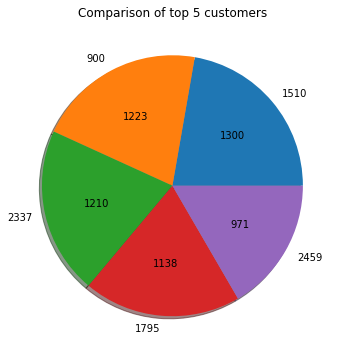

In [8]:
subplot = user_counts[:5].plot.pie(autopct=lambda p: '{:.0f}'.format(p * five_total / 100), shadow=True, figsize=(11, 6))

subplot.get_figure().gca().set_ylabel("")
subplot.get_figure().gca().set_xlabel("")
subplot.get_figure().gca().set_title("Comparison of top 5 customers")

plt.show()


[156, 324, 537, 1421]


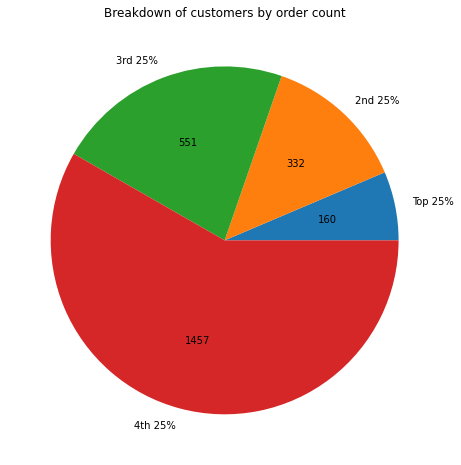

In [9]:
temp = (100. * user_counts / user_counts.sum()).sort_values(ascending=False)

count = 0
total = 0
buckets=[]
for val in temp:
    
    if total + val > 25:
        buckets.append(count)
        total = 0
        count = 0
        
    count+=1
    total+=val

print(buckets)
labels = ['Top 25%', '2nd 25%', '3rd 25%', '4th 25%']
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.pie(buckets, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(temp) / 100))
fig1.gca().set_title("Breakdown of customers by order count")
plt.show()

In [11]:
output = '''
# Top 5 products based on total count purchased:

'''

product_counts = transactions[transactions['product_id'] > 0].groupby(transactions.product_id)['quantity'].agg('sum').sort_values(ascending=False)

product_counts.head()

five_total = 0
for index, row in product_counts[:5].iteritems():
    five_total += row

table_str = product_counts[:5].to_markdown()

output += table_str

output += '''

Other products purchased {:,} times.

'''.format(transactions['quantity'].sum() - five_total)

md(output)



# Top 5 products based on total count purchased:

|   product_id |    quantity |
|-------------:|------------:|
|      6534178 | 2.16532e+08 |
|      6533889 | 1.84796e+07 |
|      6534166 | 1.39805e+07 |
|      6544236 | 2.70513e+06 |
|      1404121 | 1.6946e+06  |

Other products purchased 7,293,654 times.



In [12]:
product_counts = transactions[transactions['product_id'] > 0] \
    .groupby(transactions.product_id)['quantity'] \
    .agg('sum'). \
    sort_values(ascending=False)

product_df = product_counts \
    .reset_index() \
    .rename(columns={"product_id":"Product", "quantity":"Quantity"})
print(type(product_df[:10]))

product_df = product_counts \
    .reset_index() \
    .rename(columns={"product_id":"Product", "quantity":"Quantity"})
print(type(product_df[:10]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [14]:
output = '''
# Top 5 products based on counting orders that included them:

'''

product_counts = transactions[transactions['product_id'] > 0] \
    .groupby('product_id')['order_id'] \
    .count() \
    .sort_values(ascending=False)

five_total = 0
for index, row in product_counts[:5].iteritems():
    five_total += row

table_str = product_counts[:5].to_markdown()

output += table_str

output += '''

Other customers placed {:,} orders.

'''.format(order_count - five_total)

md(output)



# Top 5 products based on counting orders that included them:

|   product_id |   order_id |
|-------------:|-----------:|
|      1082185 |      29778 |
|      6534178 |      19820 |
|      1029743 |      14430 |
|       995242 |      12542 |
|      1106523 |       9826 |

Other customers placed 190,088 orders.



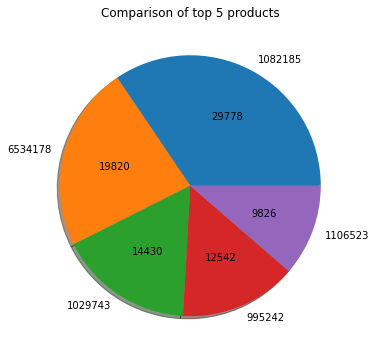

In [15]:
subplot = product_counts[:5].plot.pie(autopct=lambda p: '{:.0f}'.format(p * five_total / 100), shadow=True, figsize=(11, 6))

subplot.get_figure().gca().set_ylabel("")
subplot.get_figure().gca().set_xlabel("")
subplot.get_figure().gca().set_title("Comparison of top 5 products")

plt.show()

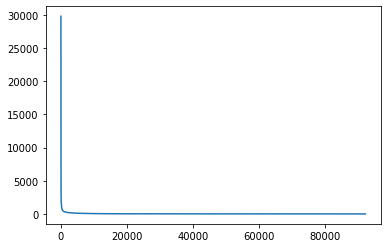

In [19]:
plt.plot(product_counts.values) 

[374, 2017, 5944, 83341]


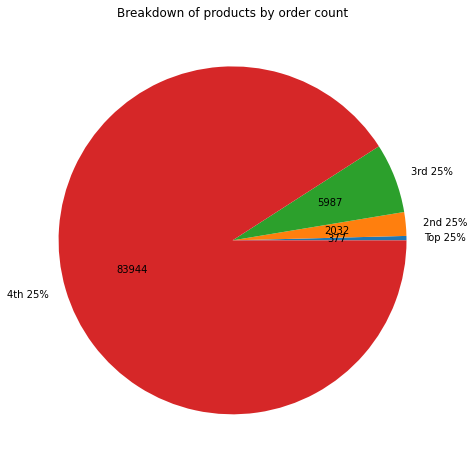

In [16]:
temp = (100. * product_counts / product_counts.sum()).sort_values(ascending=False)

count = 0
total = 0
buckets=[]
for val in temp:
    
    if total + val > 25:
        buckets.append(count)
        total = 0
        count = 0
        
    count+=1
    total+=val

print(buckets)
labels = ['Top 25%', '2nd 25%', '3rd 25%', '4th 25%']
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.pie(buckets, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(temp) / 100))
fig1.gca().set_title("Breakdown of products by order count")
plt.show()

In [20]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

grouped = transactions.groupby('order_id').agg({"product_id": lambda x: list(x)})
temp = grouped['product_id'].values


In [21]:
te = TransactionEncoder()

oht_ary = te.fit(temp).transform(temp, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
sparse_df.columns = [str(i) for i in sparse_df.columns]
top_sets = apriori(sparse_df, min_support=0.012, use_colnames=True, verbose=1, max_len=5)
top_sets['length'] = top_sets['itemsets'].apply(lambda x: len(x))

Processing 1332 combinations | Sampling itemset size 2


In [33]:
set1 = top_sets[top_sets['length'] == 1].sort_values('support', ascending=False).reset_index()[:5]['itemsets']

print(set1)


0    (1082185)
1    (6534178)
2    (1029743)
3     (995242)
4    (1106523)
Name: itemsets, dtype: object


In [36]:
set2 = top_sets[top_sets['length'] == 2].sort_values('support', ascending=False).reset_index()[:5]

print(set2)

   index   support            itemsets  length
0     37  0.012467  (1029743, 1082185)       2


In [37]:
set3 = top_sets[top_sets['length'] == 3].sort_values('support', ascending=False).reset_index()[:5]
print(set3)

Empty DataFrame
Columns: [index, support, itemsets, length]
Index: []


In [38]:
set4 = top_sets[top_sets['length'] == 4].sort_values('support', ascending=False).reset_index()[:5]
print(set4)

Empty DataFrame
Columns: [index, support, itemsets, length]
Index: []


In [39]:
set5 = top_sets[top_sets['length'] == 5].sort_values('support', ascending=False).reset_index()[:5]
print(set5)

Empty DataFrame
Columns: [index, support, itemsets, length]
Index: []
